In [1]:
import coincident
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from datetime import timedelta
from tqdm import tqdm
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

%load_ext autoreload
%autoreload 2

/home/jehayes/mambaforge/envs/coincident/lib/python3.12/site-packages/coincident/search/main.py:14: UserWarning: Unable to authenticate with Maxar API. Please set MAXAR_API_KEY environment variable.
  from coincident.search import neon_api, opentopo_api, stac, wesm


load in local data that contains spatiotemporal information for aerial lidar catalog acquisitions

In [2]:
gf_ncalm = gpd.read_parquet("/mnt/c/Users/JackE/uw/STV/lidar_hits/ncalm/ncalm_all.parquet")
gf_neon = gpd.read_parquet("/mnt/c/Users/JackE/uw/STV/lidar_hits/neon/neon_all.parquet")
gf_noaa = gpd.read_parquet("/mnt/c/Users/JackE/uw/STV/lidar_hits/noaa/noaa_all.parquet")

limit to conus

In [3]:
fn_states = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/refs/heads/master/data/geojson/us-states.json'
gf_states = gpd.read_file(fn_states)
hi_ak_pr = ["Alaska", "Hawaii", "Puerto Rico"]
gf_conus = gf_states[~gf_states["name"].isin(hi_ak_pr)].to_crs(4326)
gf_conus_bbox = gpd.GeoDataFrame(
    geometry=[gf_conus.union_all().envelope], 
    crs=gf_conus.crs
)

limit 3DEP to 2021 for viz purposes

In [4]:
gf_usgs = coincident.search.search(
    dataset="3dep",
    intersects=gf_conus_bbox,
    datetime=["2021"],
)

limit everything to 30 days or less in terms of acquisition duration

In [5]:
gf_usgs = gf_usgs[gf_usgs.duration < 31]

In [6]:
gf_ncalm = gf_ncalm.clip(gf_conus_bbox.geometry)
gf_noaa = gf_noaa.clip(gf_conus_bbox.geometry)
gf_neon = gf_neon.clip(gf_conus_bbox.geometry)

In [7]:
gf_ncalm = gf_ncalm[
    (gf_ncalm['end_datetime'] - gf_ncalm['start_datetime']).dt.days < 31
]
gf_noaa = gf_noaa[
    (gf_noaa['end_datetime'] - gf_noaa['start_datetime']).dt.days < 31
]
gf_neon = gf_neon[
    (gf_neon['end_datetime'] - gf_neon['start_datetime']).dt.days < 31
]

If we filter out based on year not being 2021, we get no hits for coincident is2 oiverlaps that satisfy an area and temporal proximity threshold

In [8]:
#gf_ncalm = gf_ncalm[
#    ((gf_ncalm['end_datetime'] - gf_ncalm['start_datetime']).dt.days < 31) &
#    ((gf_ncalm['start_datetime'].dt.year == 2021) | (gf_ncalm['end_datetime'].dt.year == 2021))
#]
#gf_noaa = gf_noaa[
#    ((gf_noaa['end_datetime'] - gf_noaa['start_datetime']).dt.days < 31) &
#    ((gf_noaa['start_datetime'].dt.year == 2021) | (gf_noaa['end_datetime'].dt.year == 2021))
#]
#gf_neon = gf_neon[
#    ((gf_neon['end_datetime'] - gf_neon['start_datetime']).dt.days < 31) &
#    ((gf_neon['start_datetime'].dt.year == 2021) | (gf_neon['end_datetime'].dt.year == 2021))
#]

In [9]:
len(gf_usgs), len(gf_ncalm), len(gf_noaa), len(gf_neon)

(58, 41, 40, 151)

In [10]:
# TODO: fix the usgs argument, not working as expected
def search_is2_hits(gdf, window_days=15, min_overlap_area=10, usgs=False):
    gdf_hits = []
    for i, row in tqdm(gdf.iterrows()):
        midpoint = row['start_datetime'] + (row['end_datetime'] - row['start_datetime']) / 2
        end = midpoint + timedelta(days=window_days)
        pad = np.abs(row['end_datetime'].day - end.day)
        secondary_datasets = [
                                    ("icesat-2", pad),
                                ]
        try:
            dataframes = coincident.search.cascading_search(
                gdf.loc[[i]] if usgs else gdf.iloc[[i]],
                secondary_datasets,
                min_overlap_area=min_overlap_area,  # km^2
            )
            if usgs:
                gf_wesm = coincident.search.wesm.load_by_fid(fids=gdf.loc[[i]].index.values)
                dataframes[0] = dataframes[0].clip(gf_wesm)
                # Project to North America Albers Equal Area Conic
                #dataframes[0] = dataframes[0].to_crs(epsg=7912)
                # Calculate area threshold in km2
                #area_threshold = min_overlap_area/len(dataframes[0])
                # filter
                #dataframes[0]['area_km2'] = dataframes[0].geometry.area / 1e6 
                #dataframes[0] = dataframes[0][dataframes[0]['area_km2'] >= area_threshold]
            if len(dataframes[0]) > 0:
                gdf_hits.append(gdf.loc[[i]] if usgs else gdf.iloc[[i]])
        except:
            continue
    return pd.concat(gdf_hits) if len(gdf_hits) > 0 else None

In [11]:
gf_neon_hits = search_is2_hits(gf_neon)
gf_ncalm_hits = search_is2_hits(gf_ncalm)
gf_noaa_hits = search_is2_hits(gf_noaa)

151it [01:47,  1.41it/s]
41it [00:38,  1.05it/s]
40it [00:47,  1.18s/it]


In [12]:
print(len(gf_neon_hits), len(gf_ncalm_hits), len(gf_noaa_hits))

22 8 19


In [13]:
gf_usgs_hits = search_is2_hits(gf_usgs, 
                               window_days=15, 
                               min_overlap_area=30, 
                               usgs=True)

0it [00:00, ?it/s]

58it [02:44,  2.84s/it]


In [14]:
gf_neon_hits_bbox = gf_neon_hits.buffer(.1).geometry.envelope.to_frame('geometry')
gf_neon_hits_bbox = gpd.GeoDataFrame(gf_neon_hits_bbox, crs=gf_neon_hits_bbox.crs).to_crs(3857)

gf_ncalm_hits_bbox = gf_ncalm_hits.buffer(.1).geometry.envelope.to_frame('geometry')
gf_ncalm_hits_bbox = gpd.GeoDataFrame(gf_ncalm_hits_bbox, crs=gf_ncalm_hits_bbox.crs).to_crs(3857)

gf_noaa_hits_bbox = gf_noaa_hits.geometry.envelope.to_frame('geometry')
gf_noaa_hits_bbox = gpd.GeoDataFrame(gf_noaa_hits_bbox, crs=gf_noaa_hits_bbox.crs).to_crs(3857)

/tmp/ipykernel_241715/4100929833.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gf_neon_hits_bbox = gf_neon_hits.buffer(.1).geometry.envelope.to_frame('geometry')
/tmp/ipykernel_241715/4100929833.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gf_ncalm_hits_bbox = gf_ncalm_hits.buffer(.1).geometry.envelope.to_frame('geometry')


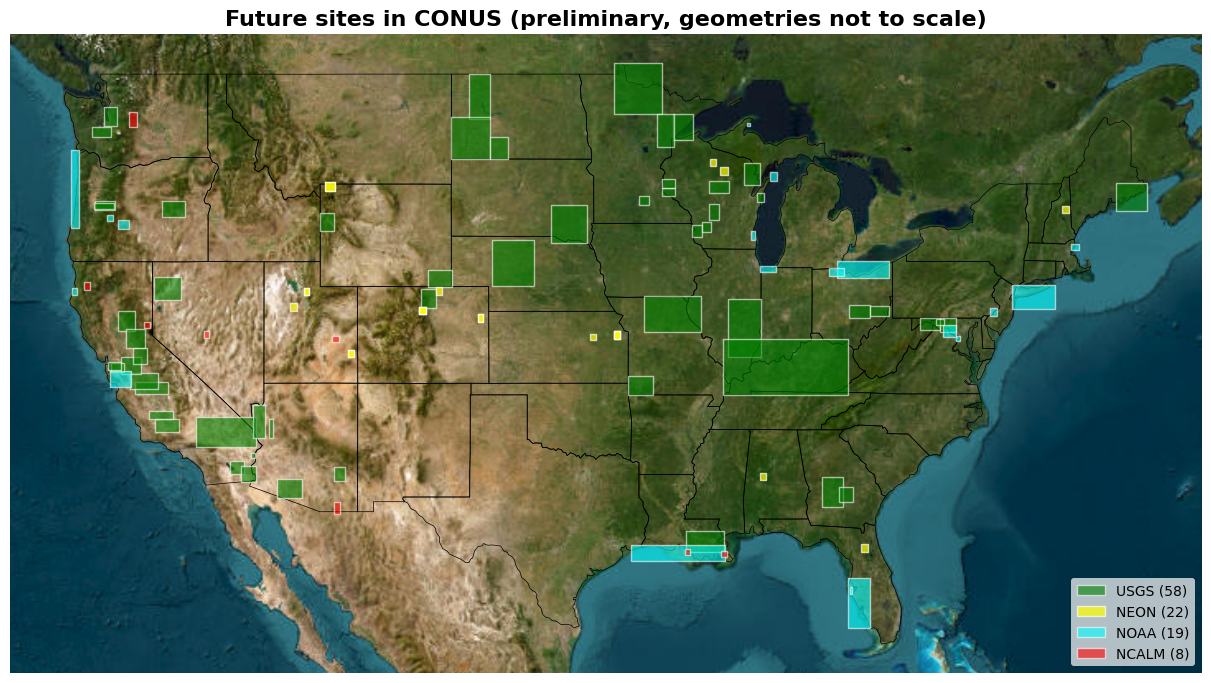

In [17]:
f, ax = plt.subplots(figsize=(12,7), layout='constrained')
gf_conus.to_crs(3857).plot(ax=ax, facecolor='none', 
              edgecolor='black', linewidth=0.5)
gf_usgs_hits.to_crs(3857).plot(ax=ax, color="green", alpha=0.6,
                               edgecolor='white')
gf_neon_hits_bbox.plot(ax=ax, color="yellow", alpha=0.7,
                               edgecolor='white')
gf_noaa_hits_bbox.plot(ax=ax, color="cyan", alpha=0.6,
                               edgecolor='white')
gf_ncalm_hits_bbox.plot(ax=ax, color="red", alpha=0.6,
                               edgecolor='white')
ctx.add_basemap(ax=ax, crs=3857,
                source=ctx.providers.Esri.WorldImagery,
                attribution=False)
ax.set(xticks=[], yticks=[], 
       xlabel="", ylabel="", 
       frame_on=False)
legend_elements = [
    Patch(facecolor='green', alpha=0.6, edgecolor='white', label=f'USGS ({len(gf_usgs_hits)})'),
    Patch(facecolor='yellow', alpha=0.7, edgecolor='white', label=f'NEON ({len(gf_neon_hits_bbox)})'),
    Patch(facecolor='cyan', alpha=0.6, edgecolor='white', label=f'NOAA ({len(gf_noaa_hits_bbox)})'),
    Patch(facecolor='red', alpha=0.6, edgecolor='white', label=f'NCALM ({len(gf_ncalm_hits_bbox)})')
]
ax.legend(handles=legend_elements, 
         loc='lower right',
         frameon=True,
         facecolor='white',
         edgecolor='none',
         framealpha=0.7)
ax.set_aspect('equal')
ax.set_title("Future sites in CONUS (preliminary, geometries not to scale)",
             fontsize=16, fontweight='bold');